In [1]:
%%writefile conf/config.yaml
# Arch	                        Start Lr	Max Steps	Decay Steps
# FullyConnectedArch	        1.00E-03	1500000	        15000	   
# FourierNetArch                1.00E-03	400000	        7500	   
# ModifiedFourierNetArch 	1.00E-03	400000	        7500	   
# SirenArch                     2.00E-05	500000	        5000	   
# DGMArch                       1.00E-03        1500000         15000           

# WARNING: Setting "exact_continuity" to true or setting the arch
# as "ModifiedFourierNetArch" increases the memory requirements of the 
# problem. Batchsizes may need to be reduced for such cases.  

defaults:
  - modulus_default
  - scheduler: tf_exponential_lr
  - optimizer: adam
  - loss: res_norm
  - _self_

scheduler: 
  decay_rate: 0.95
  decay_steps: 1000            # Change this based on arch chosen

#optimizer: 
#  lr: 1e-3                      # Change this based on arch chosen

training:
  rec_results_freq: 1000
  max_steps: 5000       # Change this based on arch chosen

custom:
  arch: "FullyConnectedArch"
  exact_continuity: false
  quasirandom: false
  adaptive_activations: false

save_filetypes : "vtk,npz"

batch_size:
  IC: 500
  interior1: 500 
  interior2: 500   
  
graph:
  func_arch: true

    

Overwriting conf/config.yaml


In [2]:
%%writefile fhnx0dd.py
from modulus.models.fully_connected import FullyConnectedArch
from modulus.models.fourier_net import FourierNetArch
from modulus.models.siren import SirenArch
from modulus.models.modified_fourier_net import ModifiedFourierNetArch
from modulus.models.dgm import DGMArch

from sympy import Symbol, Eq
from sympy import Symbol, Function, Number
from modulus.eq.pde import PDE
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import modulus
from modulus.hydra import instantiate_arch, ModulusConfig
from modulus.solver import Solver
from modulus.domain import Domain
from modulus.geometry.primitives_1d import Point1D
from modulus.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseBoundaryConstraint,
    PointwiseBoundaryConstraint,
)
from modulus.domain.validator import PointwiseValidator
from modulus.key import Key
from modulus.node import Node
from modulus.eq.pde import PDE
from modulus.geometry import Parameterization
from sympy import Symbol, Eq, Abs, tanh, Or, And
from modulus.utils.io import (
    csv_to_dict,
    ValidatorPlotter,
    InferencerPlotter,
)

from modulus.models.deeponet import DeepONetArch
from modulus.domain.constraint.continuous import DeepONetConstraint

def generateExactSolution(t,dt,x0,rate,P):
    
    n2=int(t/dt)
    n = int(t/(dt*rate))
    Sol=np.zeros(n)
    Sol[0]=x0
    Sol2=np.zeros(n2)
    Sol2[0]=x0
    T=0
    k=0
    while(k<n2-1):
        x=Sol2[k]
        Sol2[k+1]=x*(x-0.2)*(1-x)*dt +  x
        if ((k+1)%rate == 0):
            T=T+1
            Sol[T] = Sol2[k+1]         
        k=k+1
    return Sol


class SpringMass(PDE):
    name = "SpringMass"

    def __init__(self):

        t = Symbol("t")
        input_variables = {"t": t}

        x1 = Function("x1")(*input_variables)

        self.equations = {}
        self.equations["ode_x1"] = x1*(1-x1)*(x1-0.2) -x1.diff(t)
        
@modulus.main(config_path="conf", config_name="config")
def run(cfg: ModulusConfig) -> None:
    
    # make list of nodes to unroll graph on
    sm = SpringMass()
    sm.pprint()
    #sm_net = FullyConnectedArch(
    #    input_keys=[Key("t"), Key("K")],
    #    output_keys=[Key("x1")],
    #)
    #nodes = sm.make_nodes() + [
    #    sm_net.make_node(name="network")
    #]

    
    if cfg.custom.arch == "FullyConnectedArch":
        flow_net = FullyConnectedArch(
            input_keys=[Key("t"), Key("K")],
            output_keys=[Key("x1")],
            adaptive_activations=cfg.custom.adaptive_activations,
        )
    elif cfg.custom.arch == "FourierNetArch":
        flow_net = FourierNetArch(
            input_keys=[Key("t"), Key("K")],
            output_keys=[Key("x1")],
            adaptive_activations=cfg.custom.adaptive_activations,
        )
    elif cfg.custom.arch == "SirenArch":
        flow_net = SirenArch(
            input_keys=[Key("t"), Key("K")],
            output_keys=[Key("x1")],
            #normalization={"x": (-2.5, 2.5), "y": (-2.5, 2.5), "z": (-2.5, 2.5)},
        )
    elif cfg.custom.arch == "ModifiedFourierNetArch":
        flow_net = ModifiedFourierNetArch(
            input_keys=[Key("t"), Key("K")],
            output_keys=[Key("x1")],
            adaptive_activations=cfg.custom.adaptive_activations,
        )
    elif cfg.custom.arch == "DGMArch":
        flow_net = DGMArch(
            input_keys=[Key("t"), Key("K")],
            output_keys=[Key("x1")],
            layer_size=128,
            adaptive_activations=cfg.custom.adaptive_activations,
        )
    else:
        sys.exit(
            "Network not configured for this script. Please include the network in the script"
        )
    
    
    
    nodes = sm.make_nodes() + [
        flow_net.make_node(name="network")
    ]
    
    
   
    # add constraints to solver
    # make geometry
    geo = Point1D(0)
    t_max = 10.0
    t_symbol = Symbol("t")
    u_symbol = Symbol("x1")
    k_symbol= Symbol("K")
    time_range = {t_symbol: (0, t_max)}
    k_range= {k_symbol:(0.3,0.8)}

    # make domain
    domain = Domain()

    # initial conditions
    IC = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"x1": k_symbol},
        batch_size=cfg.batch_size.IC,
        parameterization={**{t_symbol:0},**k_range},
        #quasirandom=cfg.custom.quasirandom,
    )
    domain.add_constraint(IC, name="IC")

    
    
    # solve over given time period
    interior1 = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"ode_x1": 0.0},
        batch_size=cfg.batch_size.interior1,
        parameterization={**time_range,**k_range},
        #criteria=And(t_symbol > 0, t_symbol < 3),
        lambda_weighting={
            "ode_x1": 1.0,
        }
    )
    domain.add_constraint(interior1, "interior1")
    
    
    interior2 = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"ode_x1": 0.0},
        batch_size=cfg.batch_size.interior2,
        parameterization={**time_range,**k_range},
        criteria=And(t_symbol > 3, t_symbol < 10),
    )
    domain.add_constraint(interior2, "interior2")
    
    
    
    
        
    ##Data driven constraing
    T=np.empty([0])
    K=np.empty([0])
    SOLs=np.empty([0])
    krange= [(0.3 + 0.01*i*0.5) for i in range(1,100)]

    deltaT = 0.01
    rate = 100
    t = np.linspace(0, t_max, int((t_max/(deltaT)) /rate) )
    t = np.expand_dims(t, axis=-1)
    
    for KR in krange:
        
        
        T=np.append(T,t)
        K = np.append(K,np.full_like (t,KR))
        SOLs=np.append(SOLs,np.array(generateExactSolution(t_max,deltaT,KR,rate,KR)))
    
    
    
    t = np.expand_dims(T, axis=-1)
    t = np.expand_dims(t, axis=-1)
    t = np.expand_dims(t, axis=-1)

    k = np.expand_dims(K, axis=-1)
    k = np.expand_dims(k, axis=-1)
    k = np.expand_dims(k, axis=-1)
    
    Sol = np.expand_dims(SOLs, axis=-1)
    Sol = np.expand_dims(Sol, axis=-1)
    Sol = np.expand_dims(Sol, axis=-1)
    
    print(np.shape(t),"training set")
    
    
    invar_numpy = {"t": t,"k":k}
    outvar_numpy = {
        "x1": Sol
    }

    
    data = DeepONetConstraint.from_numpy(
        nodes=nodes,
        invar={"t":t,"K":k},
        outvar={"x1":Sol},
        batch_size=10,
    )
    domain.add_constraint(data, "data")
    
    
    
    
    # add validation data
  
 
   
    T=np.empty([0])
    K=np.empty([0])
    SOLs=np.empty([0])
    krange= [(0.303 + 0.01*i*0.5) for i in range(1,100)]
    #krange2= [(0.4 + 0.01*i*0.1) for i in range(1,100)]
    #krange3=[(0.5 + 0.01*i*0.5) for i in range(1,100)]
    #krange= np.append(krange, krange2)
    #krange= np.append(krange,krange3)
    
    deltaT = 0.01
    rate = 100
    t = np.linspace(0, t_max, int((t_max/(deltaT)) /rate) )
    t = np.expand_dims(t, axis=-1)
    for KR in krange:
        
        
        T=np.append(T,t)
        K = np.append(K,np.full_like (t,KR))
        SOLs=np.append(SOLs,np.array(generateExactSolution(t_max,deltaT,KR,rate,KR)))
    
    
    t=np.expand_dims(T,axis=-1)
    k=np.expand_dims(K,axis=-1)
    sol=np.expand_dims(SOLs,axis=-1)
    
    invar_numpy = {"t": t,"K":k}
    outvar_numpy = {
        "x1": sol
    }
    
    
    validator = PointwiseValidator(
        nodes=nodes, invar=invar_numpy, true_outvar=outvar_numpy, batch_size=1024,plotter=ValidatorPlotter()
    )
    domain.add_validator(validator)
    
    
    # make solver
    slv = Solver(cfg, domain)

    # start solver
    slv.solve()


if __name__ == "__main__":
    run()


Overwriting fhnx0dd.py


In [3]:
!rm -r outputs/fhnx0dd || true ##se não limpar o output ele aproveita o treinamento, mesmo se mudar o modelo
!python fhnx0dd.py


[03:33:30] - JIT using the NVFuser TorchScript backend
[03:33:30] - Disabling JIT because functorch does not work with it.
[03:33:30] - JitManager: {'_enabled': False, '_arch_mode': <JitArchMode.ONLY_ACTIVATION: 1>, '_use_nvfuser': True, '_autograd_nodes': False}
[03:33:30] - GraphManager: {'_func_arch': True, '_debug': False, '_func_arch_allow_partial_hessian': True}
ode_x1: (1 - x1)*(x1 - 0.2)*x1 - x1__t
[03:33:33] - Arch Node: network has been converted to a FuncArch node.
[03:33:33] - Arch Node: network has been converted to a FuncArch node.
(990, 1, 1, 1) training set
[03:33:33] - Installed PyTorch version 1.13.1+cu117 is not TorchScript supported in Modulus. Version 1.13.0a0+d321be6 is officially supported.
[03:33:33] - attempting to restore from: outputs/fhnx0dd
[03:33:33] - optimizer checkpoint not found
[03:33:33] - model network.0.pth not found
[03:33:34] - [step:          0] record constraint batch time:  6.981e-02s
[03:33:35] - [step:          0] record validators time:  1.

2
(990, 1)
2
2


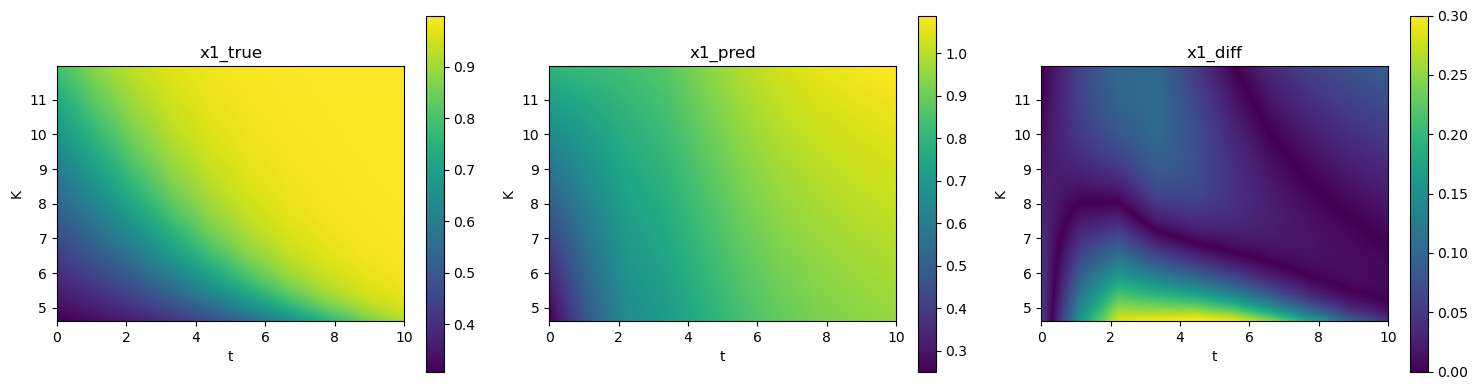

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
def find(list_to_check, item_to_find):
    return [idx for idx, value in enumerate(list_to_check) if value == item_to_find]

base_dir = "outputs/fhnx0dd/validators/"

data = np.load(base_dir + "validator.npz", allow_pickle=True)
data = np.atleast_1d(data.f.arr_0)[0]

def interpolate_2D( size, invar, *outvars):
        "Interpolate 2D outvar solutions onto a regular mesh"

        print(len(invar))
        assert len(invar) == 2

        # define regular mesh to interpolate onto
        xs = [invar[k][:, 0] for k in invar]
        extent = (xs[0].min(), xs[0].max(), xs[1].min(), xs[1].max())
        xyi = np.meshgrid(
            np.linspace(extent[0], extent[1], size),
            np.linspace(extent[2], extent[3], size),
            indexing="ij",
        )

        # interpolate outvars onto mesh
        outvars_interp = []
        for outvar in outvars:
            outvar_interp = {}
            for k in outvar:
                outvar_interp[k] = scipy.interpolate.griddata(
                    (xs[0], xs[1]), outvar[k][:, 0], tuple(xyi)
                )
            outvars_interp.append(outvar_interp)

        return [extent] + outvars_interp


def call(invar, true_outvar, pred_outvar):



        # interpolate 2D data onto grid
        print(len(invar))
        extent, true_outvar, pred_outvar = interpolate_2D(
                200, invar, true_outvar, pred_outvar
            )
        ndim=2
        # make plots
        dims = list(invar.keys())
        fs = []
        for k in pred_outvar:
            f = plt.figure(figsize=(3 * 5, 4), dpi=100)
            for i, (o, tag) in enumerate(
                zip(
                    [true_outvar[k], pred_outvar[k], ((true_outvar[k] - pred_outvar[k])**2)**(0.5) ],
                    ["true", "pred", "diff"],
                )
            ):
                plt.subplot(1, 3, 1 + i)
                if ndim == 1:
                    plt.plot(invar[dims[0]][:, 0], o[:, 0])
                    plt.xlabel(dims[0])
                elif ndim == 2:
                    plt.imshow(o.T, origin="lower", extent=extent)
                    
                    plt.xlabel(dims[0])
                    plt.ylabel(dims[1])
                    if(tag=="diff"):
                       
                        plt.clim(0,0.3)
                    plt.colorbar()
                plt.title(f"{k}_{tag}")
            plt.tight_layout()
            fs.append((f, k))
     
    
    
invar={
       "t":data["t"],"K":data["K"]*15
      }
print(len(invar))
out={"x1":data["pred_x1"],
     }
out_t={"x1":data["true_x1"],
      }

print (np.shape(out_t["x1"]))
call(invar,out_t,out)


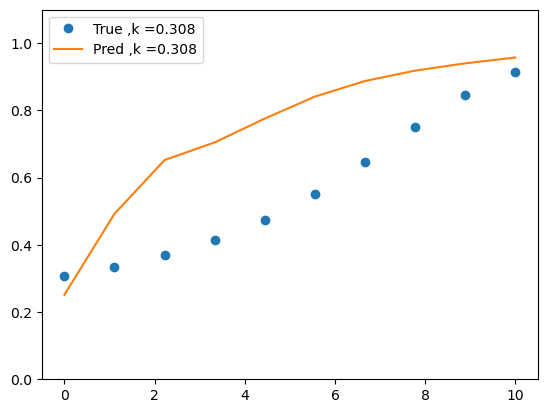

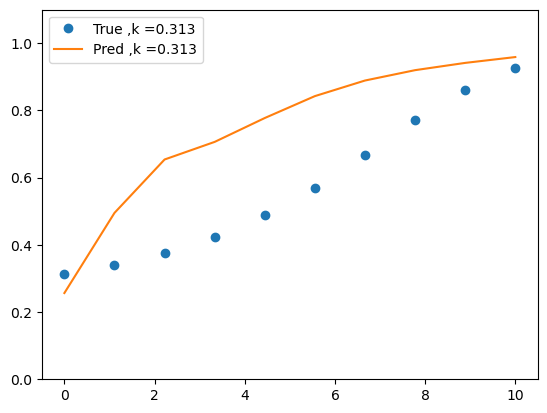

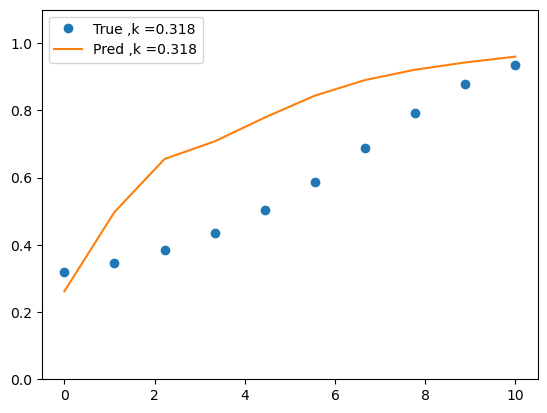

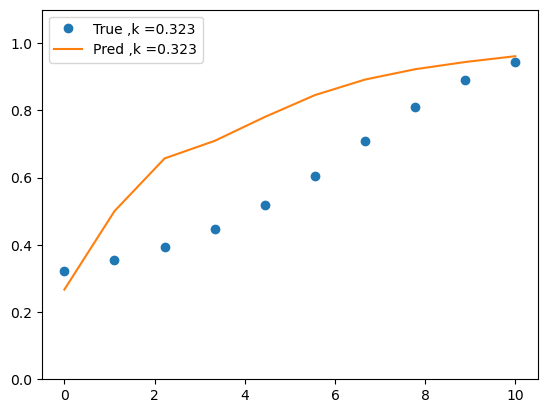

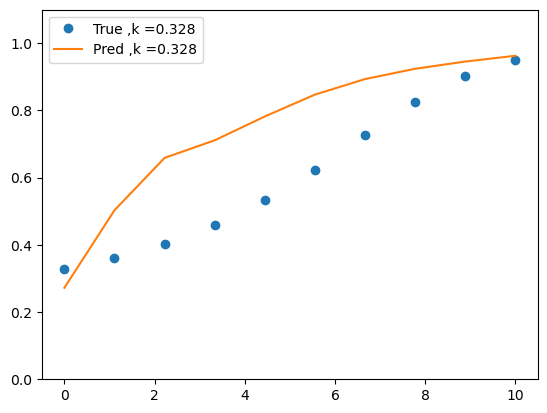

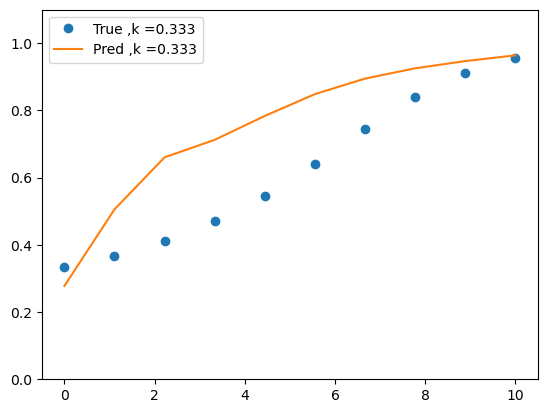

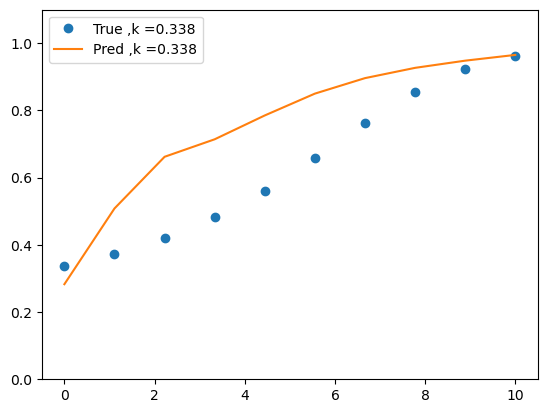

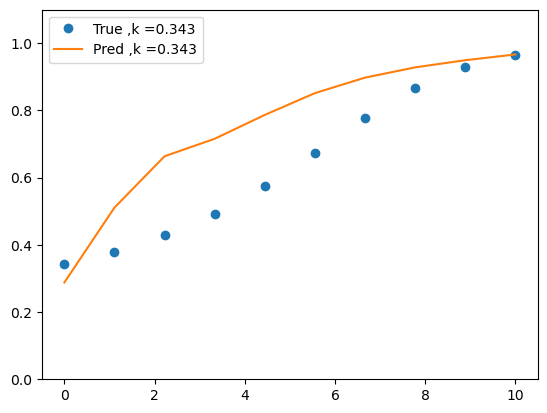

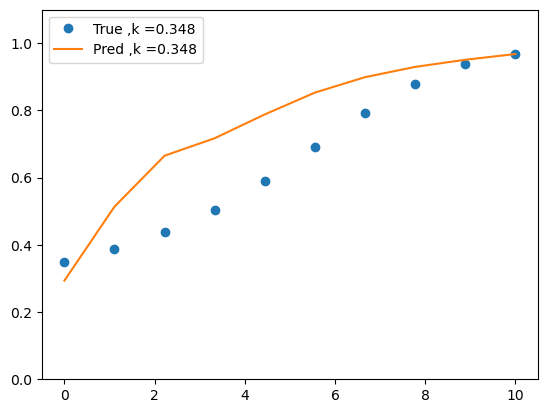

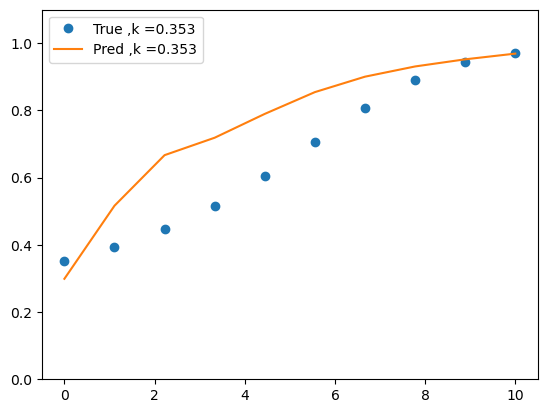

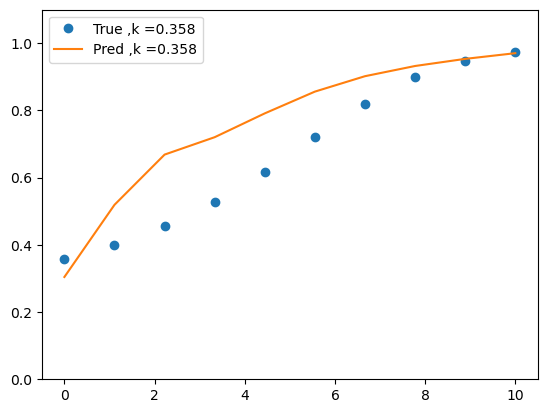

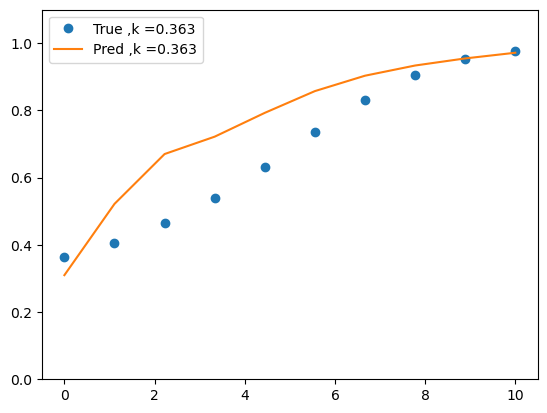

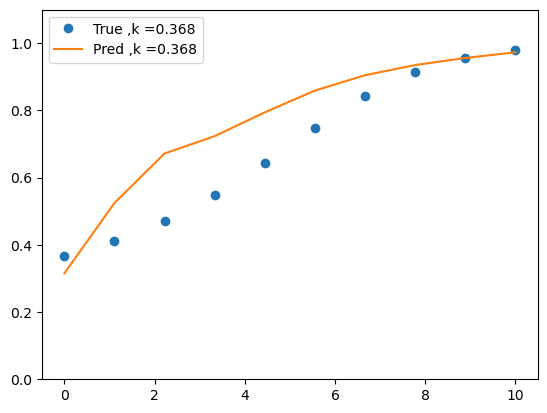

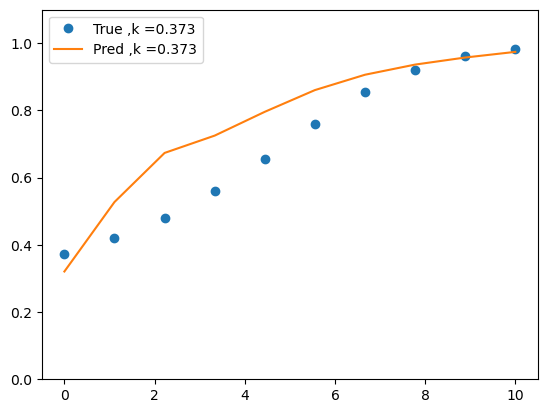

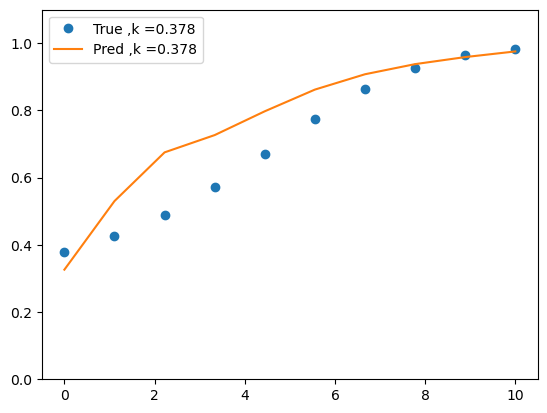

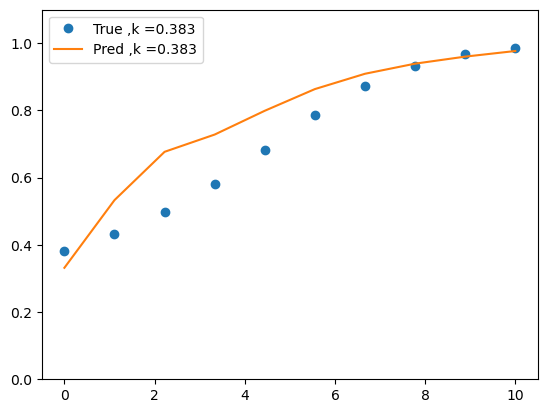

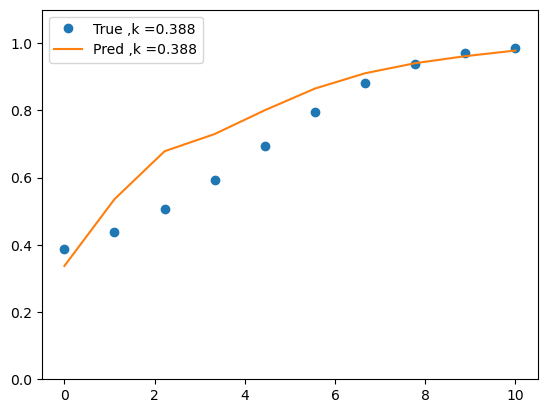

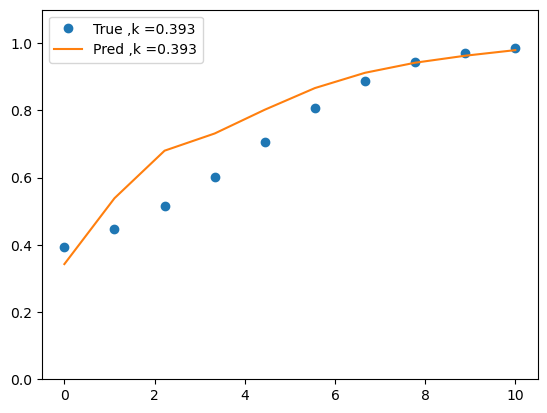

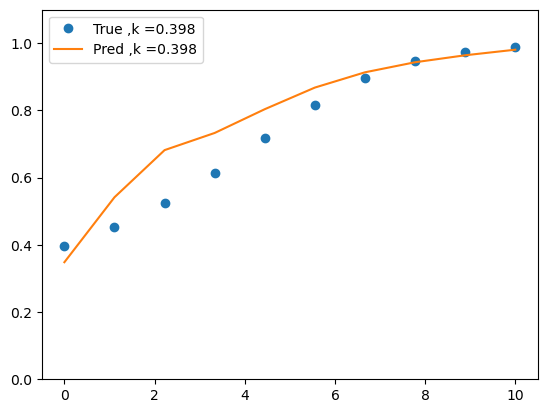

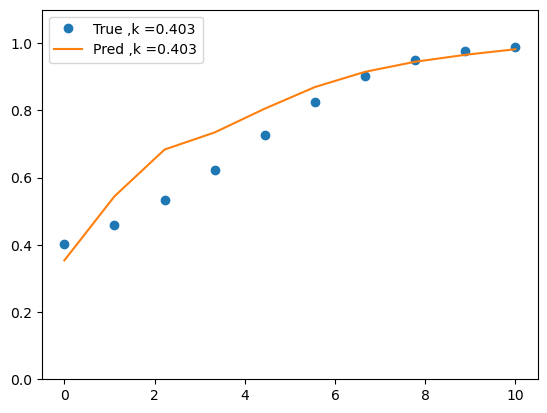

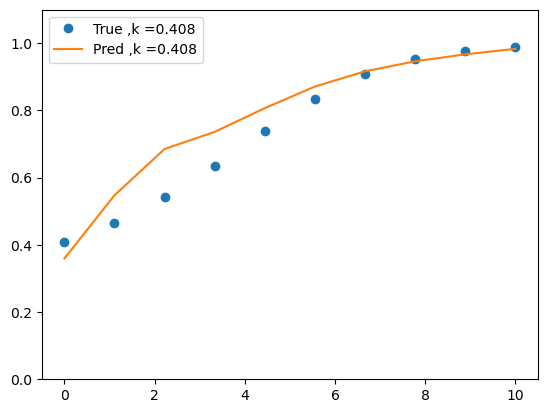

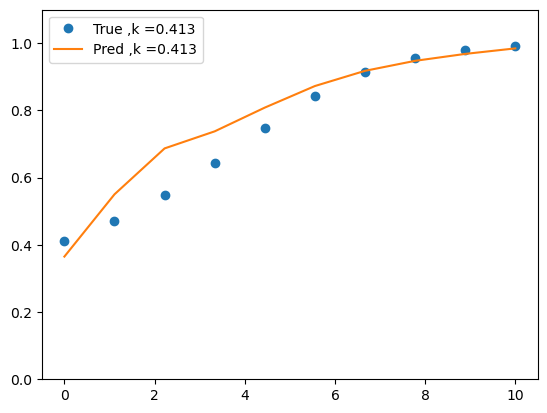

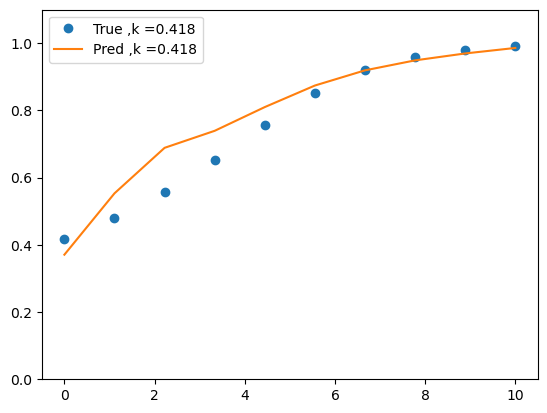

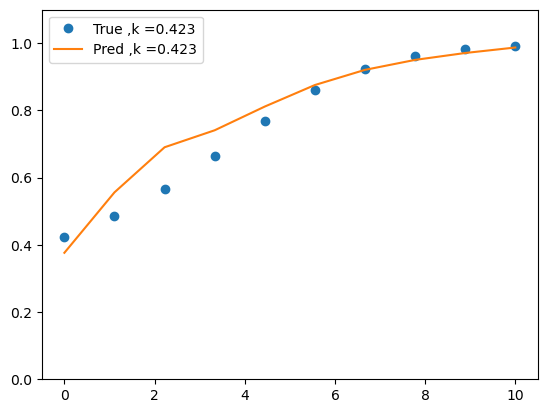

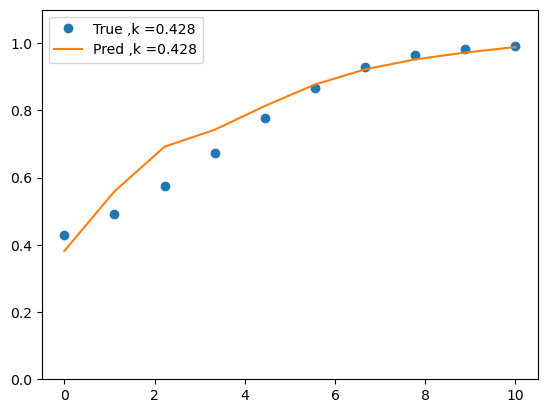

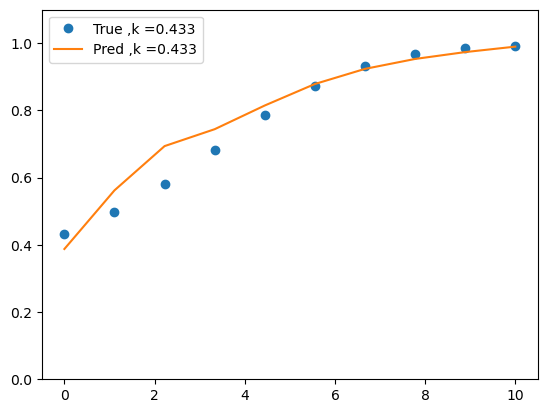

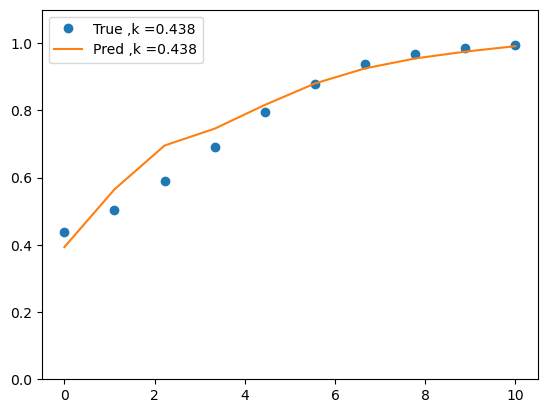

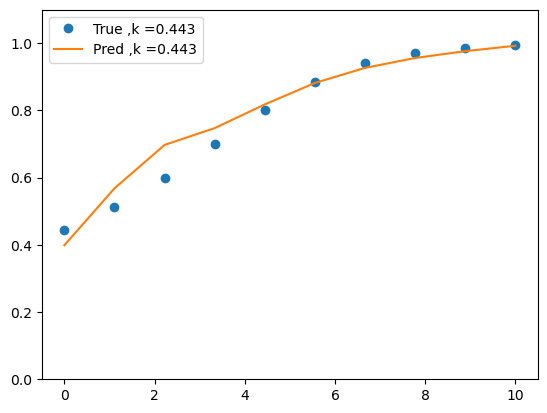

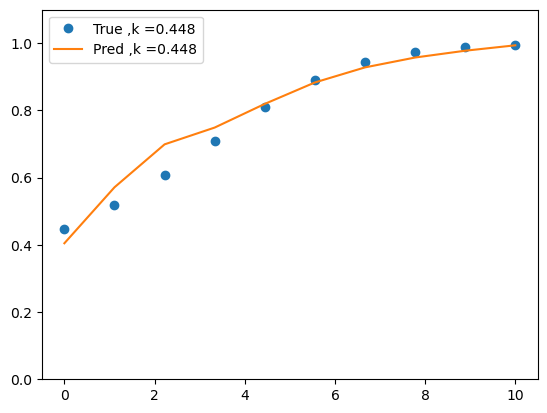

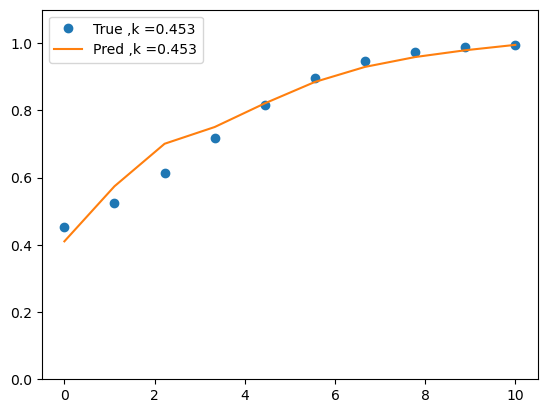

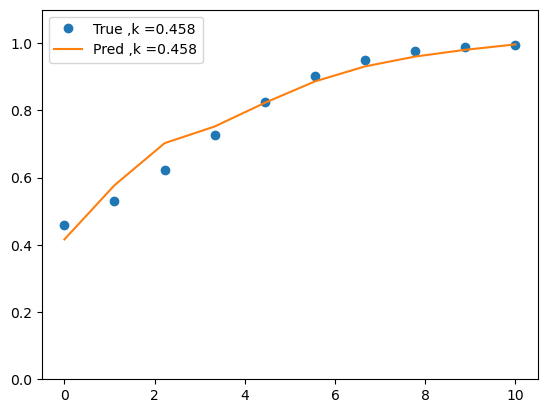

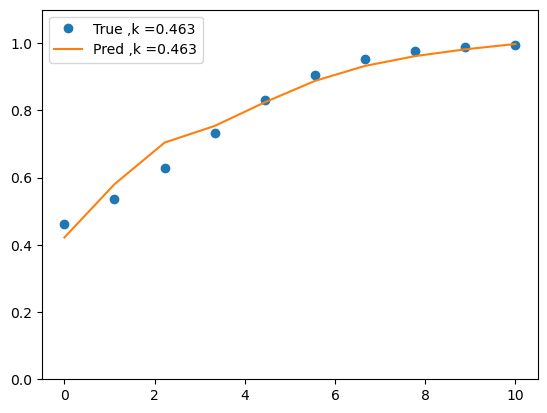

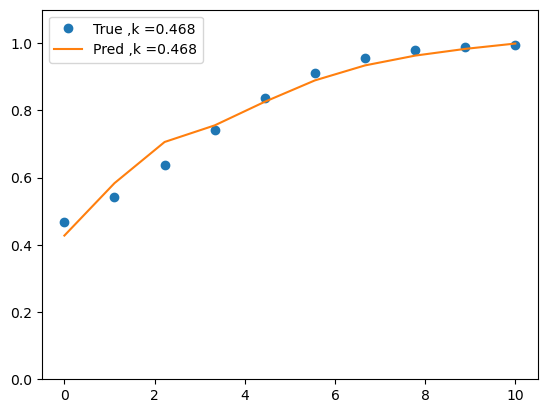

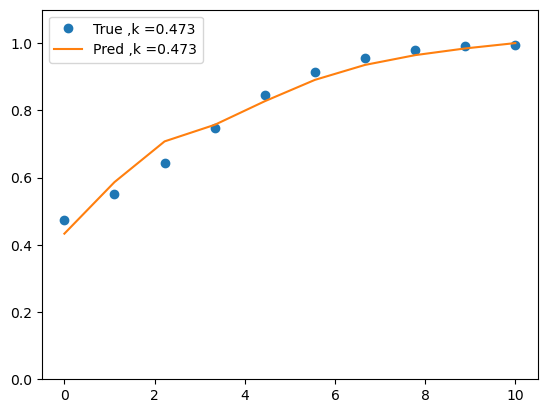

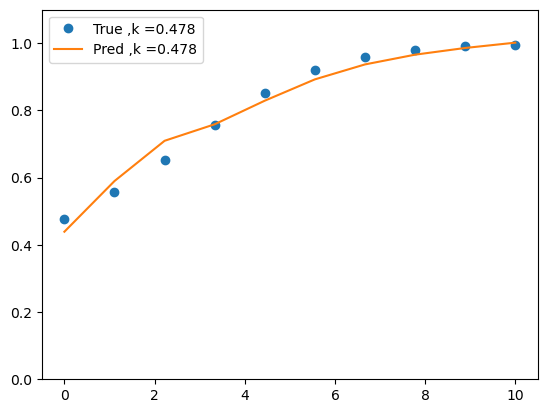

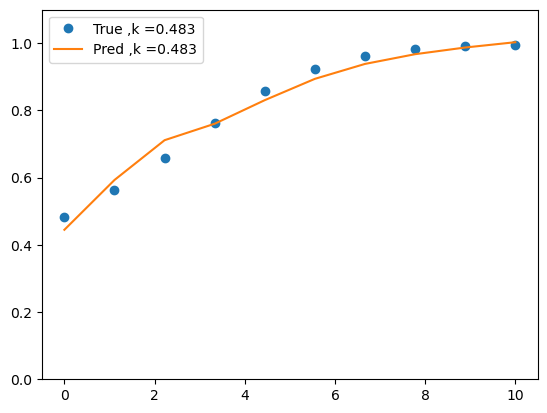

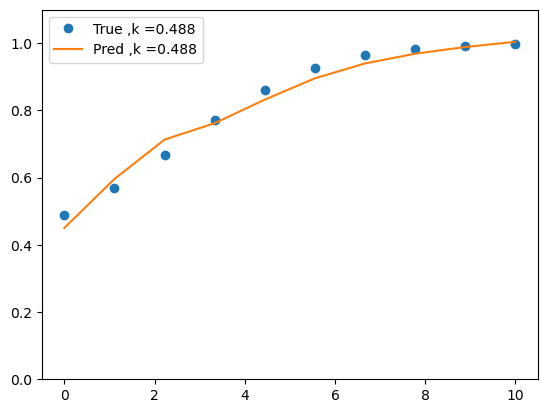

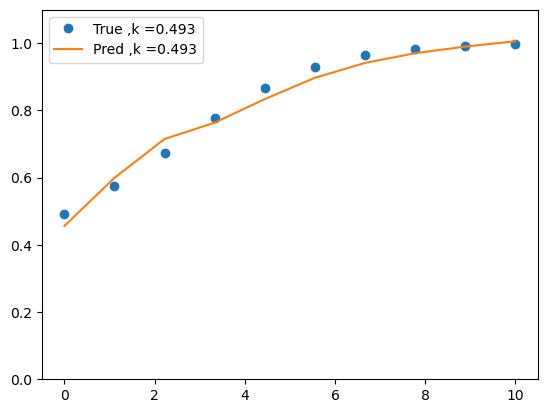

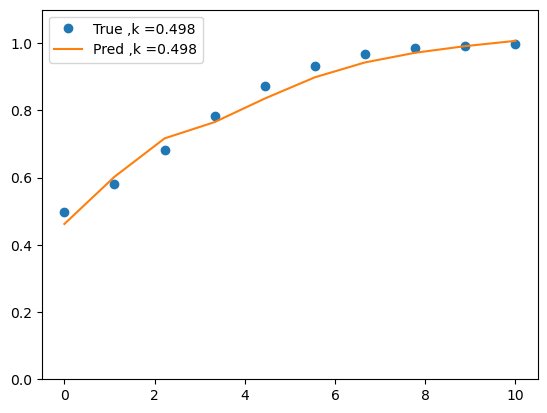

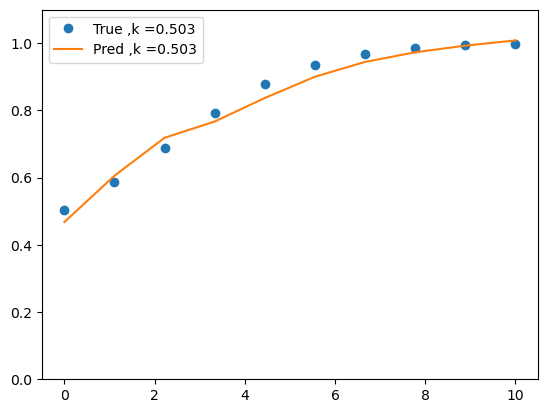

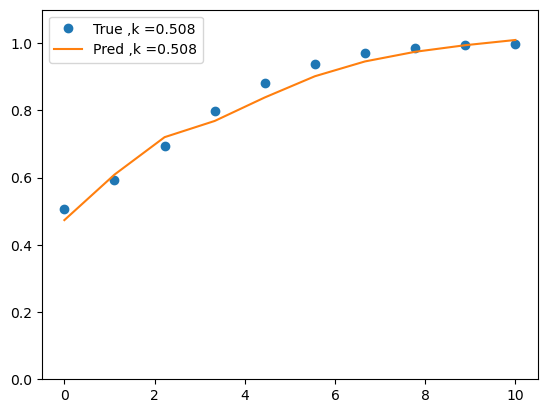

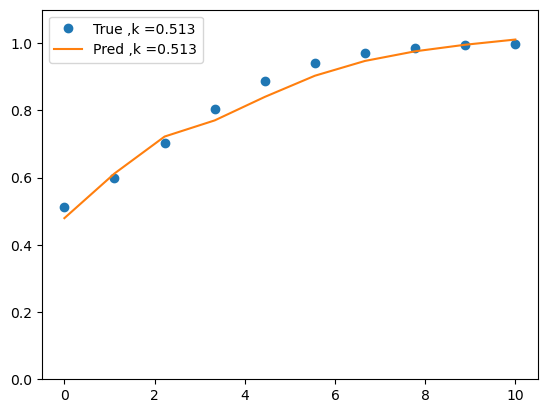

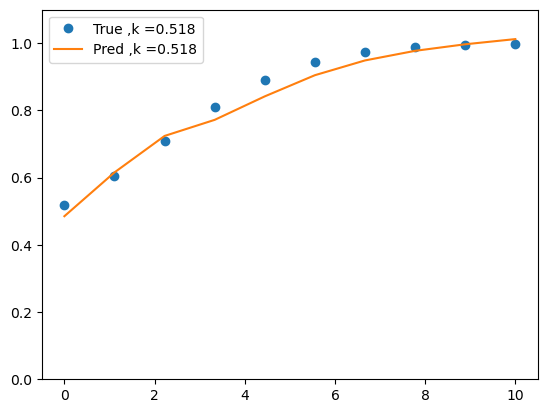

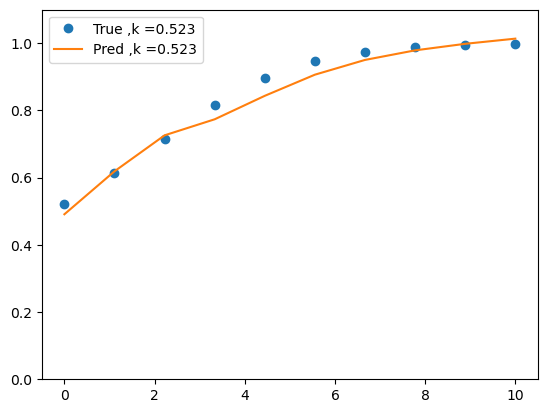

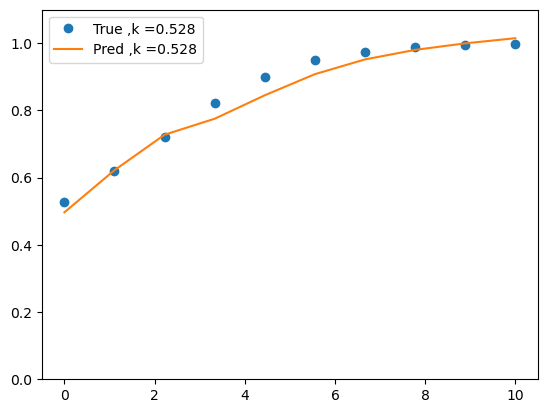

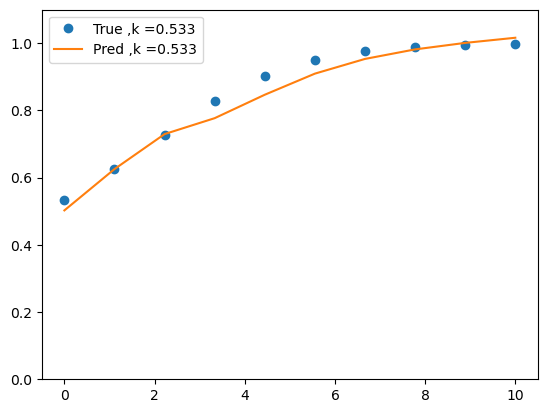

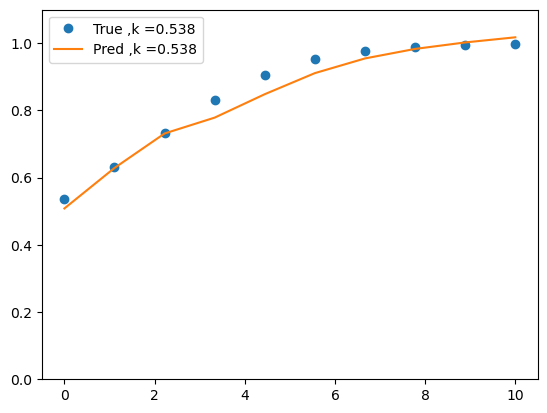

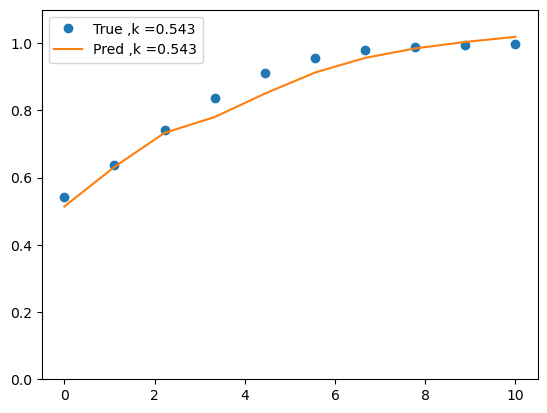

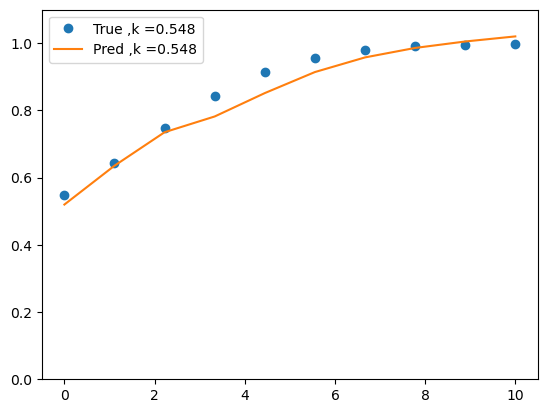

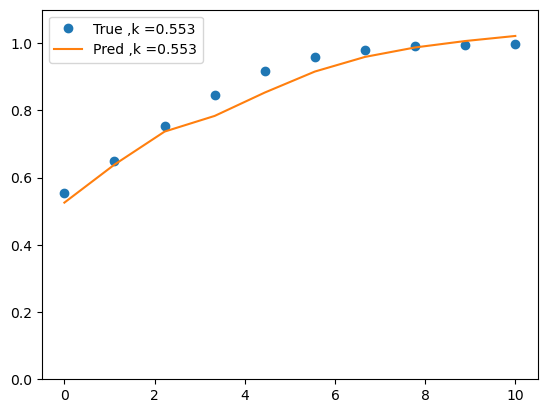

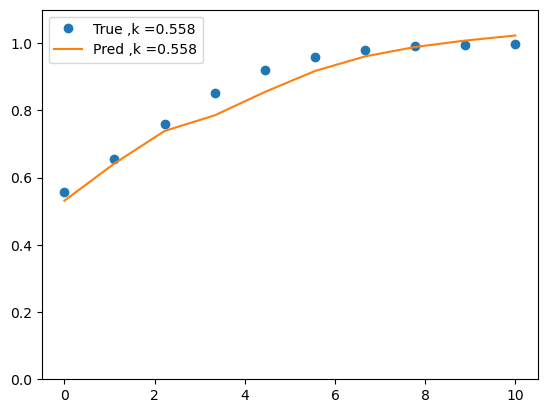

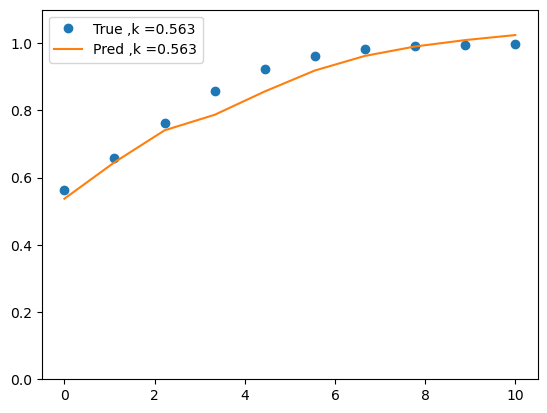

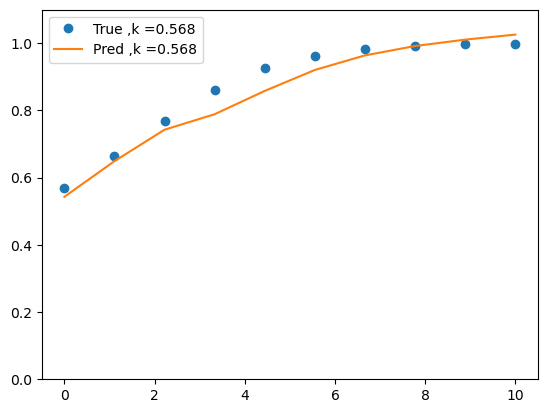

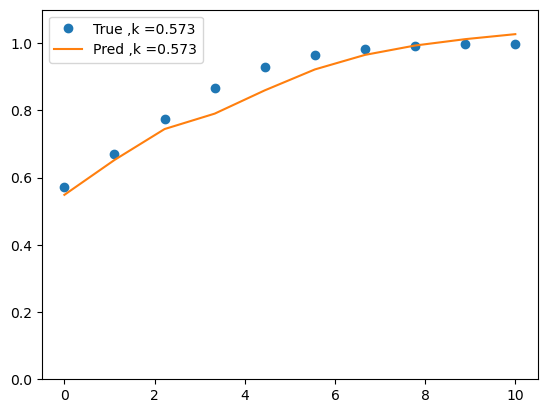

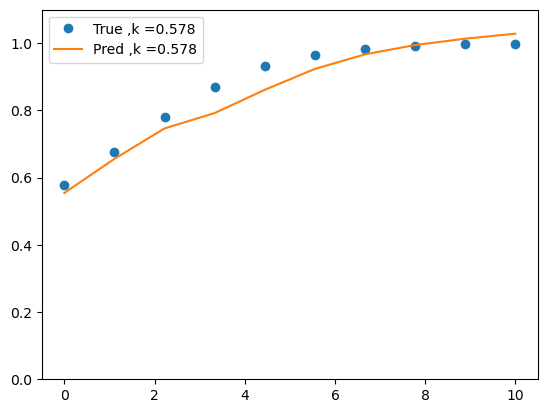

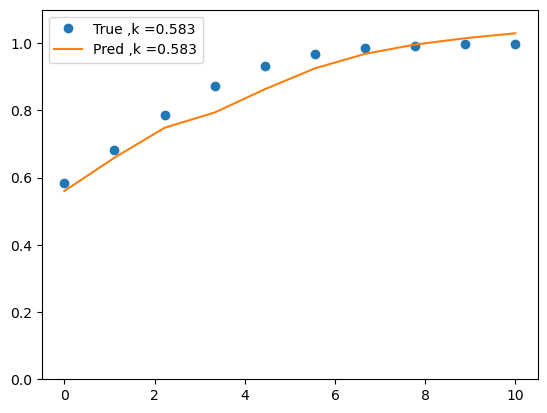

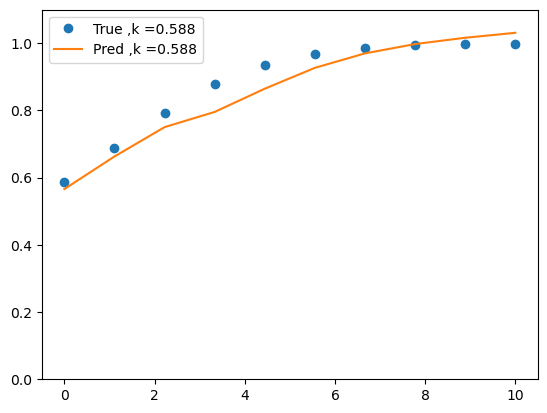

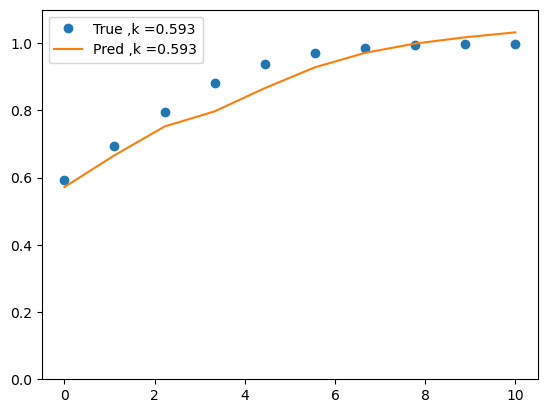

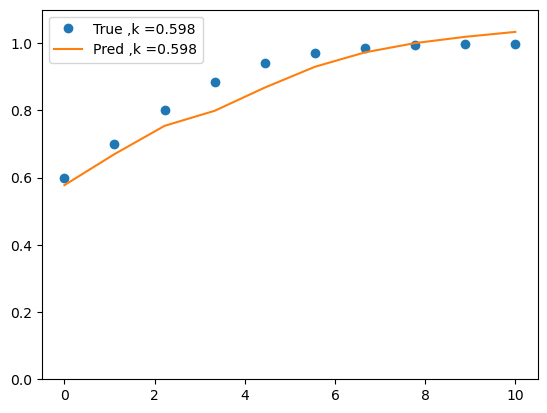

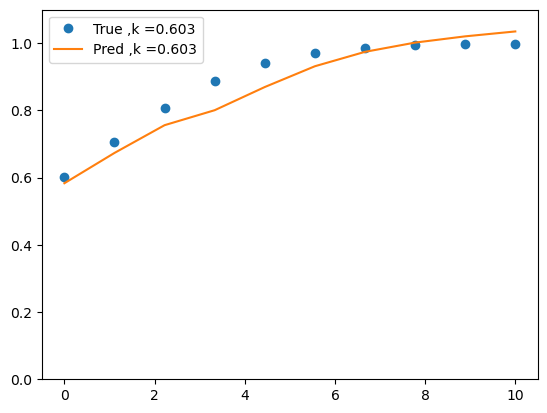

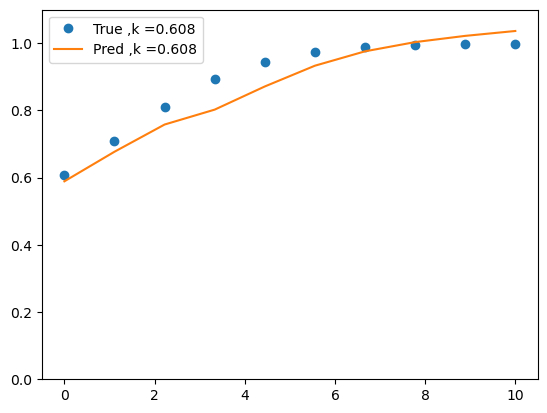

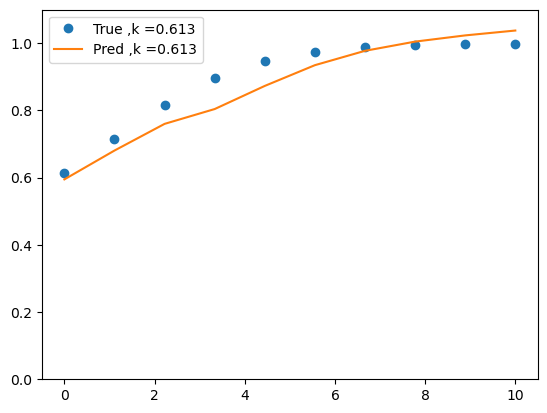

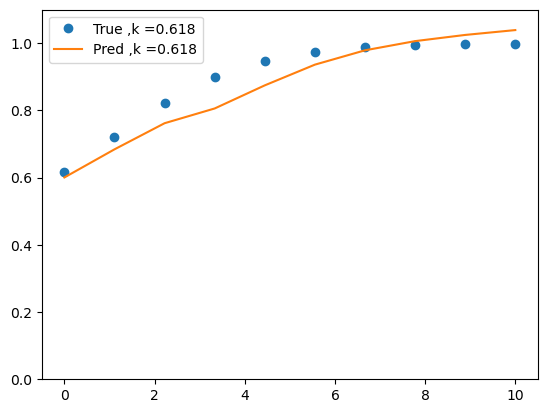

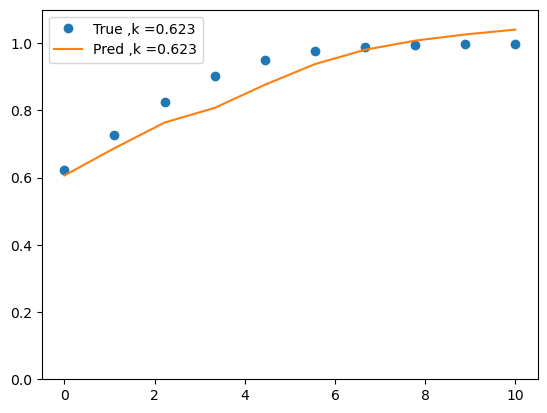

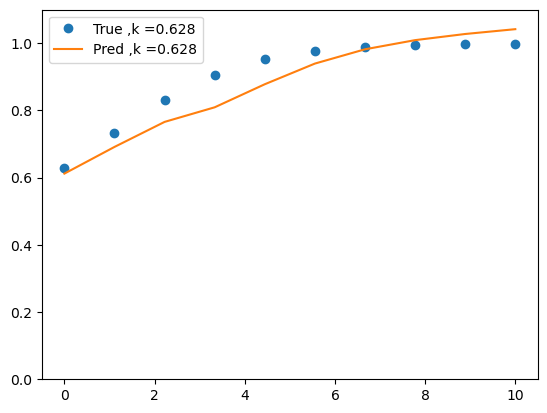

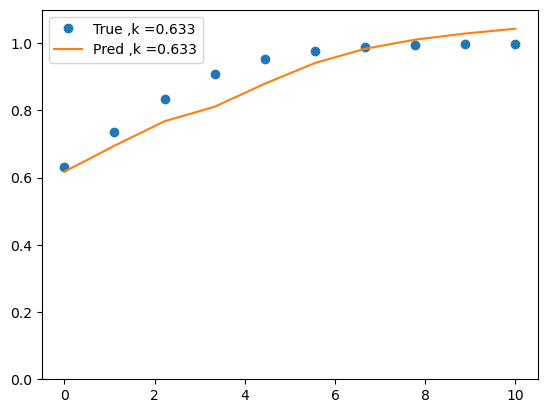

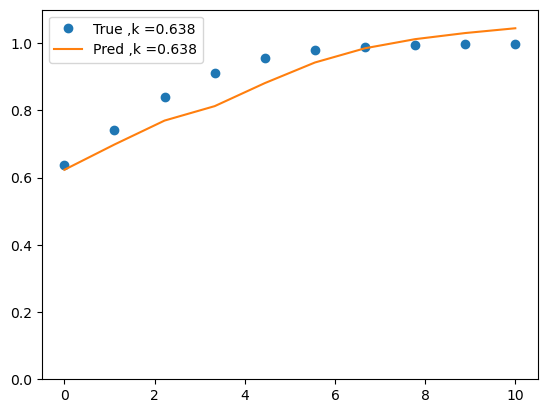

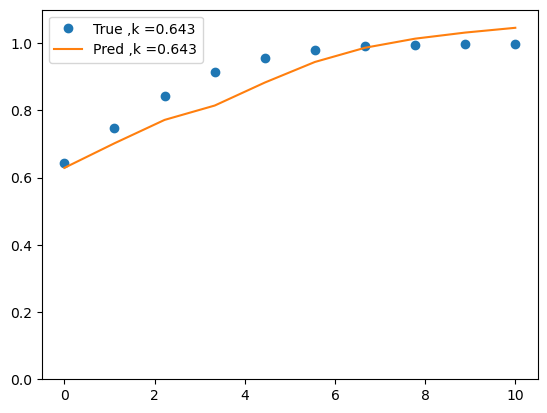

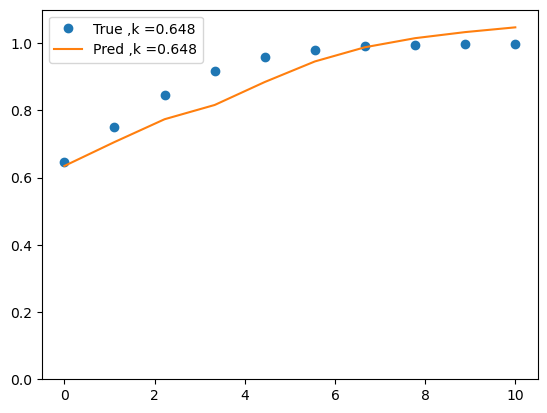

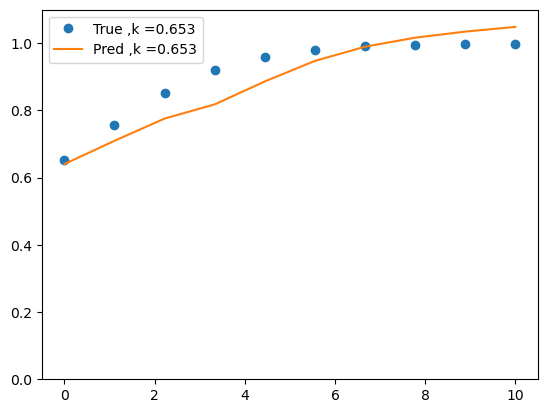

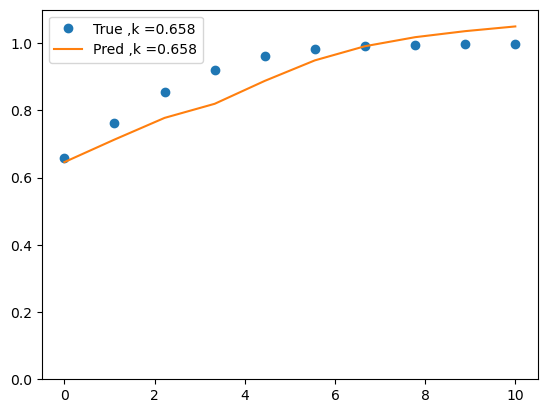

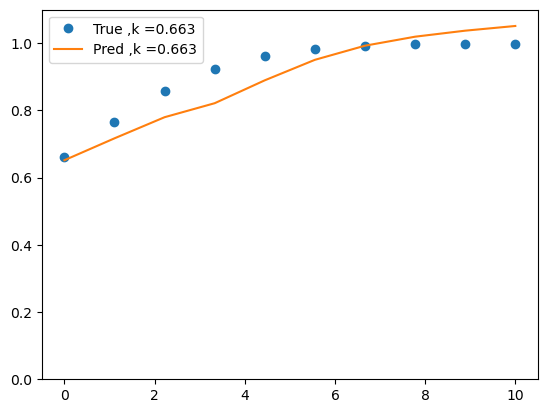

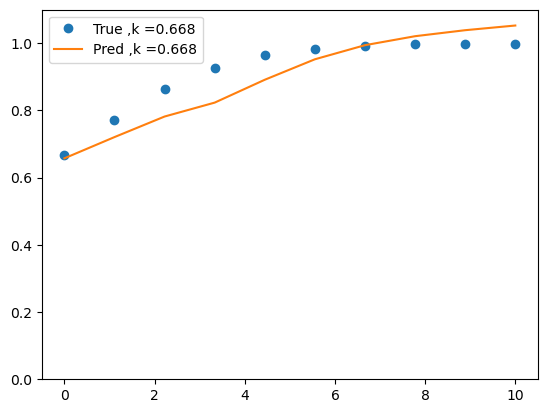

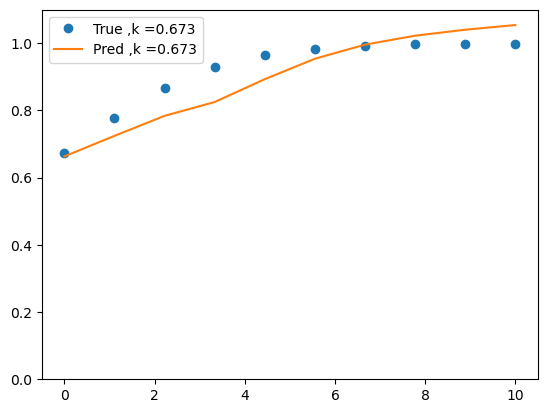

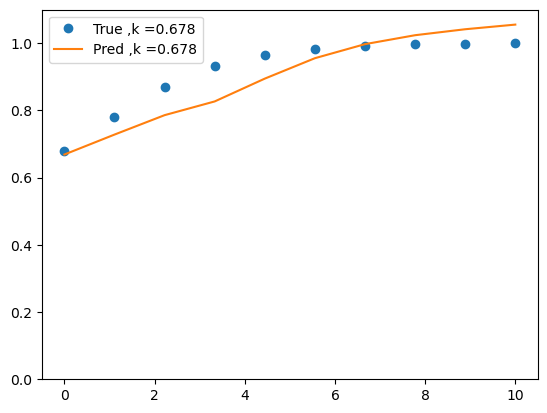

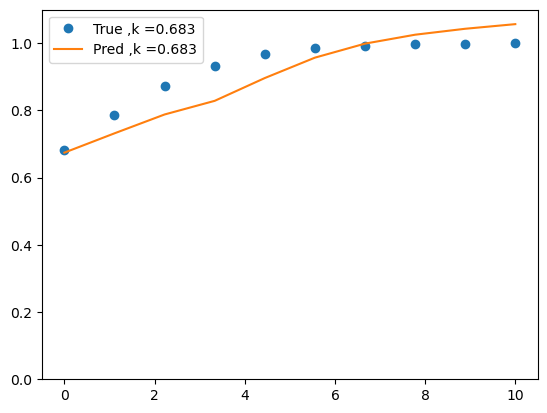

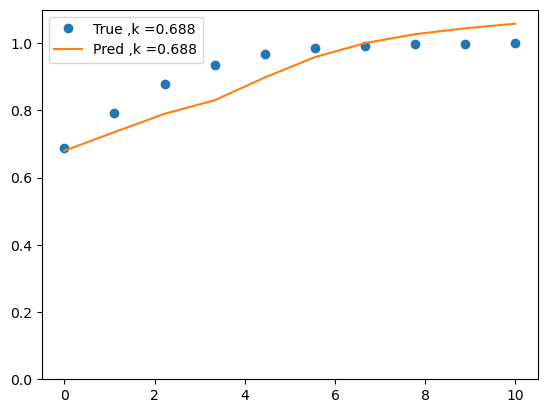

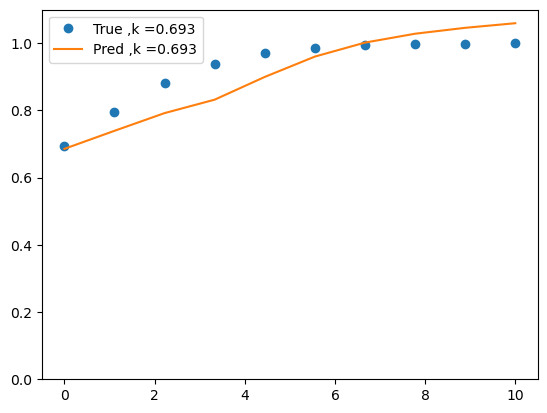

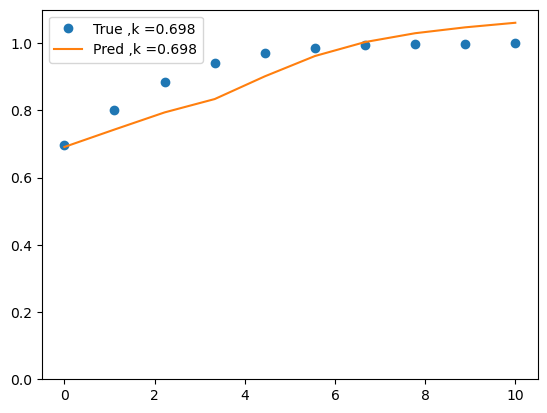

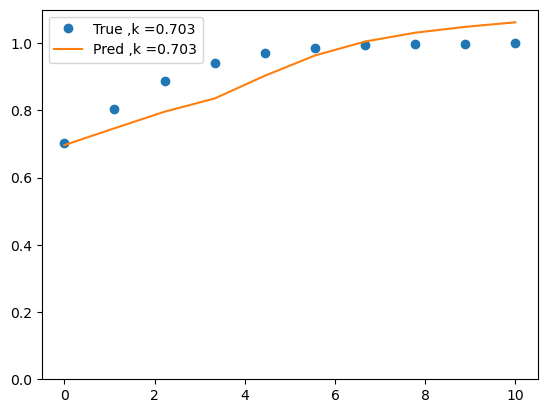

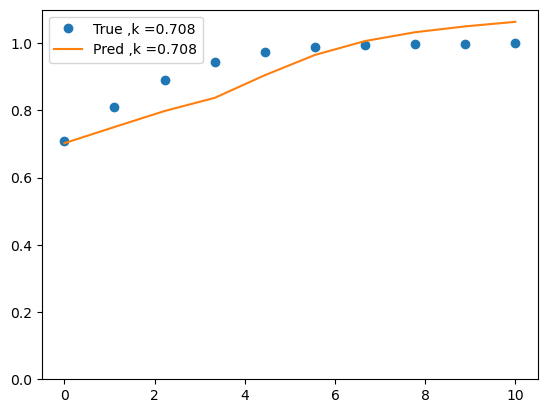

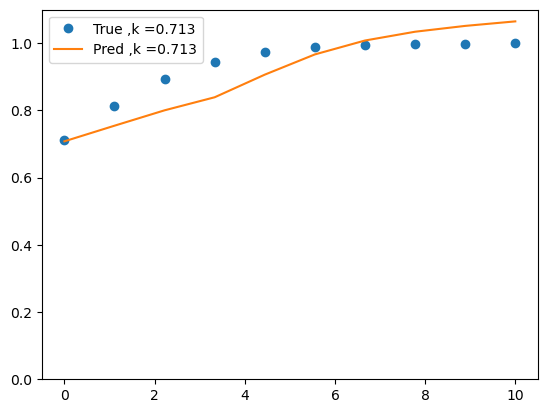

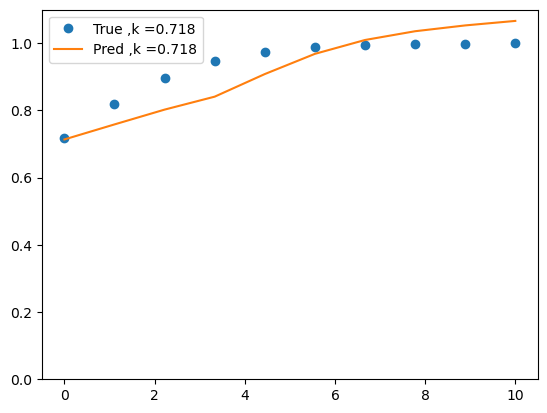

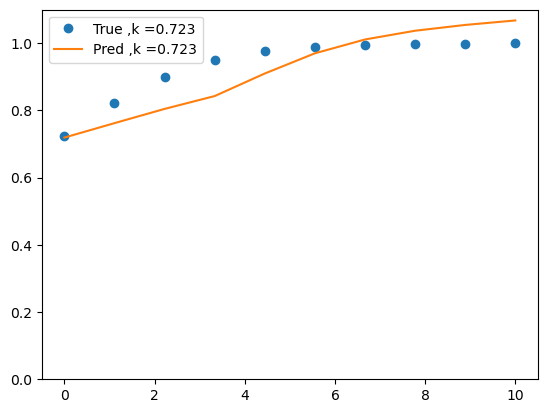

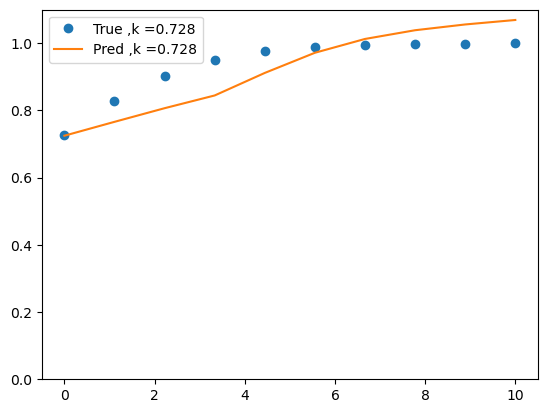

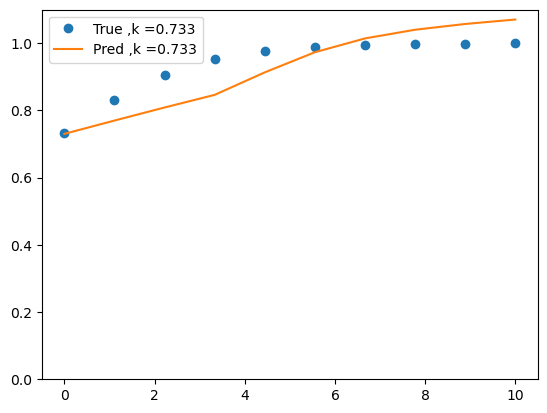

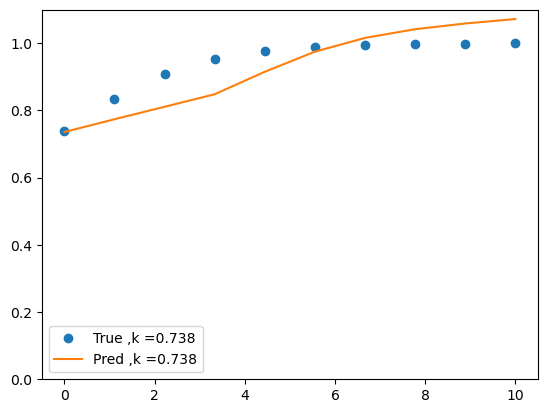

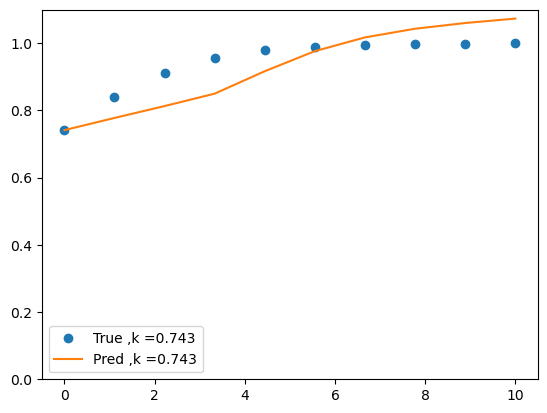

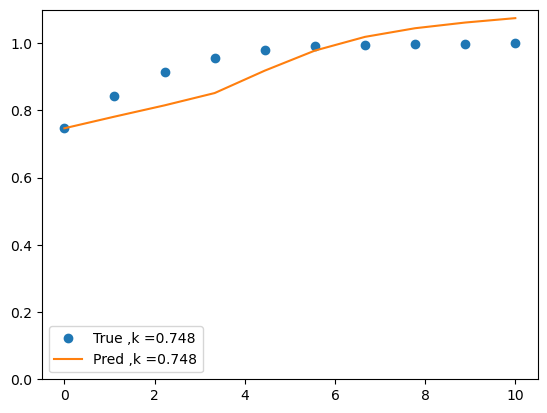

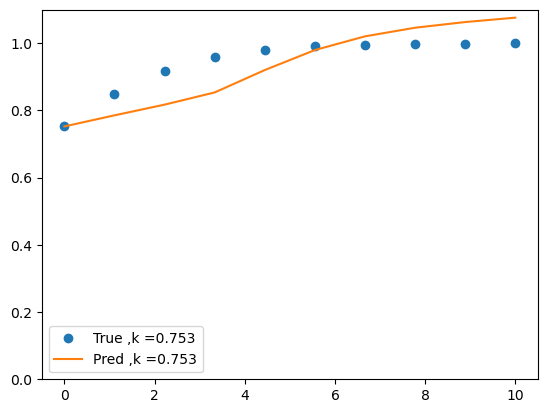

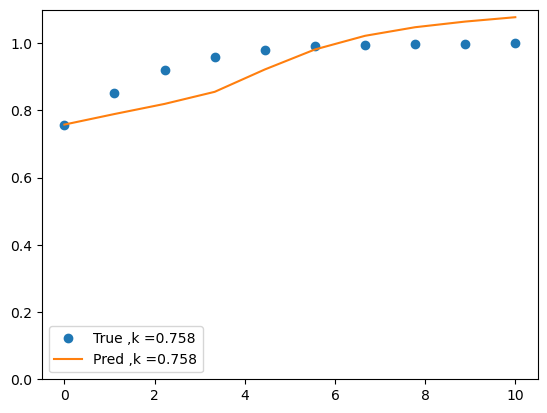

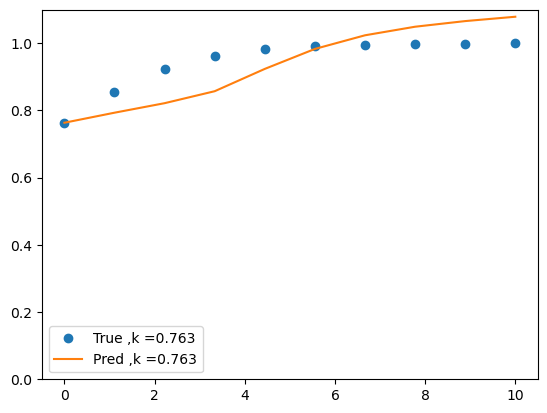

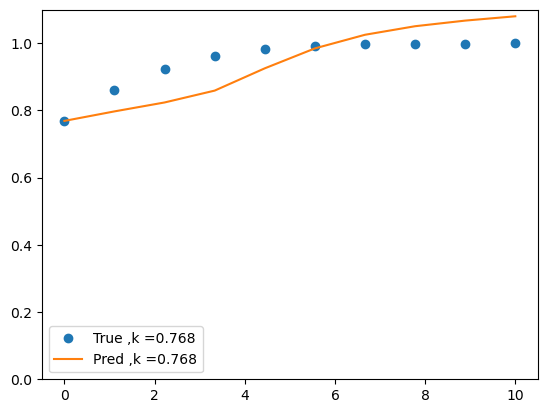

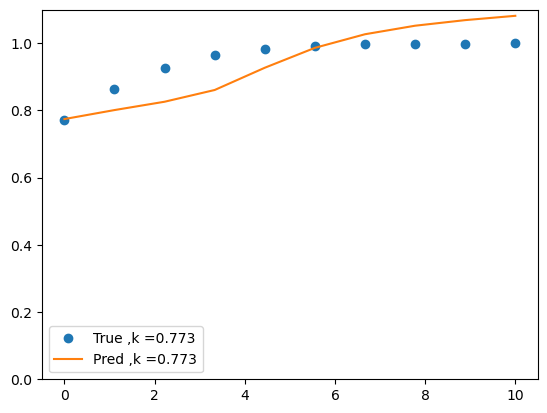

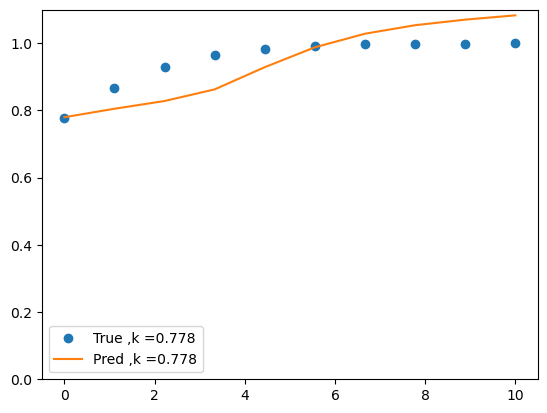

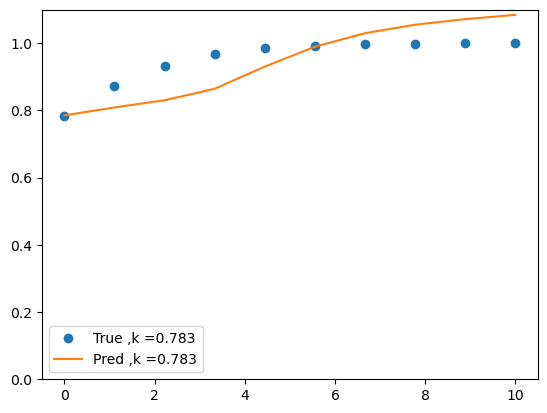

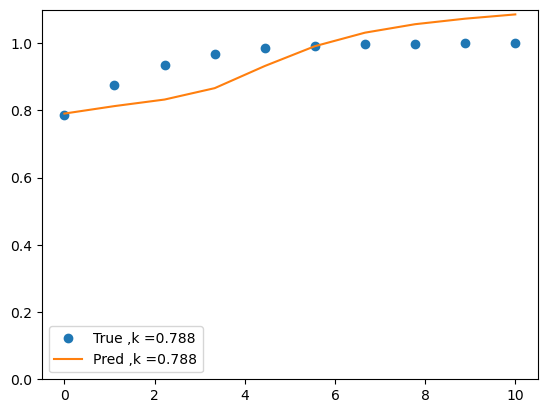

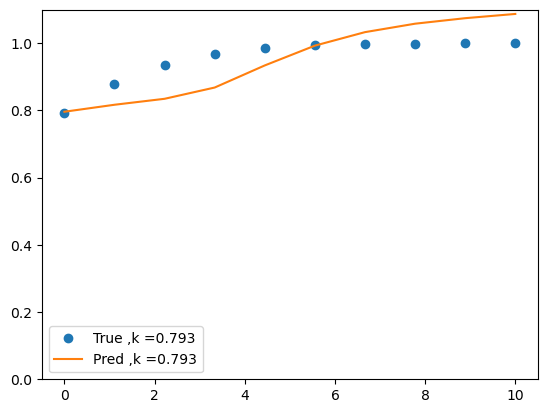

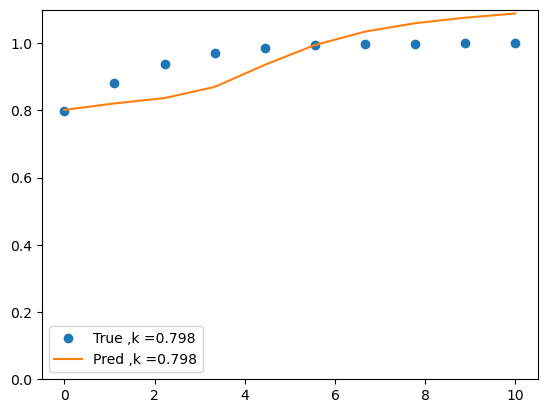

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def find(list_to_check, item_to_find):
    return [idx for idx, value in enumerate(list_to_check) if value == item_to_find]

base_dir = "outputs/fhnx0dd/validators/"

# plot in 1d
data = np.load(base_dir + "validator.npz", allow_pickle=True)
data = np.atleast_1d(data.f.arr_0)[0]

ks=np.unique(data["K"])
t=np.unique(data["t"])
d=np.full_like(ks,0)

for k in ks:
    i=find(data["K"],k)
    #print(i)
    x=data["true_x1"][i]
    pred=data["pred_x1"][i]
    d=np.mean(x-pred)
    plt.ylim(0,1.1)
    plt.plot(t,x,"o",label="True ,k ="+ str(k))
    plt.plot(t,pred,label="Pred ,k ="+ str(k))
    plt.legend(loc="best")
    plt.show()
    